In [1]:
# Sample API
import mae6225
import simulation
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 100.0
dt   = 1e-3
tmax = 5.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc']
face_vars   = ['velc', 'hvar', 'ibmf', 'forc']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'neumann']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
simulation.set_initial_velocity(gridx, gridy, 'velc')
simulation.update_outflow_bc(gridx, 'velc', False)

In [4]:
t  = 0.0
nt = 0

ins_stats = dict()

while t <= tmax:
    
    # Compute mass in the domain
    Qin = simulation.get_qinqout(gridx, 'velc', bc_type_u, True) + \
          simulation.get_qinqout(gridy, 'velc', bc_type_v, True)
    
    # Compute convective outflow velocity and update BC
    convvel = simulation.get_convvel(gridx, 'velc')    
    simulation.update_outflow_bc(gridx, 'velc', convvel, dt, True)
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    if tmax == 0:
        mae6225.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    else:
        mae6225.ins.predictor_AB2(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    # Compute mass out of the domain
    Qout = simulation.get_qinqout(gridx, 'velc', bc_type_u, False) + \
           simulation.get_qinqout(gridy, 'velc', bc_type_v, False)
    
    # Rescale velocity at outflow and update BC
    simulation.rescale_velocity(gridx, 'velc', bc_type_u, Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', False)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ins_stats['ites'], ins_stats['res'] = mae6225.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                       maxiter=3000, tol=1e-7)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(mae6225.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        mae6225.io.display_stats(t, ins_stats)   
    
    t += dt
    nt += 1
    

------------ Time = 0.0 ---------------
Number of poisson iterations    : 1
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0


------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : 3000
Final poisson residual : 5.254654589870815e-07
Max, Min, U   : 1.004131131282533, -1.0
Max, Min, V   : 0.010331825858133073, -0.010331825858133073
Max, Min, P   : 0.5799543273377334, -0.5784944880505932
Max, Min, DIV : 2.9671707241850473e-07, -2.9562944600701815e-07


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : 2548
Final poisson residual : 9.998992795162341e-08
Max, Min, U   : 1.0080064211058526, -1.0
Max, Min, V   : 0.019871577327159357, -0.019871577327159357
Max, Min, P   : 0.5607403667928241, -0.5567485391227512
Max, Min, DIV : 5.7481686910332286e-08, -5.8362828875280215e-08


------------ Time = 0.03000000000000002 ---------------
Number

------------ Time = 0.24000000000000019 ---------------
Number of poisson iterations    : 1018
Final poisson residual : 9.999518979557132e-08
Max, Min, U   : 1.0571630543064938, -1.0
Max, Min, V   : 0.17507959759137087, -0.17507959759137087
Max, Min, P   : 0.35745961609405197, -0.27057923052242666
Max, Min, DIV : 6.811530051109571e-08, -7.938657176076447e-08


------------ Time = 0.25000000000000017 ---------------
Number of poisson iterations    : 996
Final poisson residual : 9.997816415264845e-08
Max, Min, U   : 1.0588694029913117, -1.0
Max, Min, V   : 0.18008450688571415, -0.18008450688571415
Max, Min, P   : 0.35464519568736463, -0.26404632561747304
Max, Min, DIV : 6.821733222750481e-08, -7.98265160639744e-08


------------ Time = 0.2600000000000002 ---------------
Number of poisson iterations    : 972
Final poisson residual : 9.998101395764756e-08
Max, Min, U   : 1.0604957461649147, -1.0
Max, Min, V   : 0.18512266346748094, -0.18512266346748094
Max, Min, P   : 0.3519789858411868, -

------------ Time = 0.47000000000000036 ---------------
Number of poisson iterations    : 603
Final poisson residual : 9.996787524865863e-08
Max, Min, U   : 1.0789871028379894, -1.0
Max, Min, V   : 0.3154764632587292, -0.3154764632587292
Max, Min, P   : 0.319803370638604, -0.16794888268638075
Max, Min, DIV : 7.020866377160928e-08, -9.043758297799798e-08


------------ Time = 0.48000000000000037 ---------------
Number of poisson iterations    : 588
Final poisson residual : 9.99993356328095e-08
Max, Min, U   : 1.0792846442618957, -1.0
Max, Min, V   : 0.32015933649460604, -0.32015933649460604
Max, Min, P   : 0.31902863060958636, -0.16500546311081696
Max, Min, DIV : 7.033169158177088e-08, -9.104469511633795e-08


------------ Time = 0.4900000000000004 ---------------
Number of poisson iterations    : 575
Final poisson residual : 9.999663821615237e-08
Max, Min, U   : 1.0795124826907905, -1.0
Max, Min, V   : 0.3246850943850852, -0.3246850943850852
Max, Min, P   : 0.31829680570948227, -0.1621

------------ Time = 0.7000000000000005 ---------------
Number of poisson iterations    : 676
Final poisson residual : 9.996796400038171e-08
Max, Min, U   : 1.0834394364292435, -1.0
Max, Min, V   : 0.42175453563197723, -0.42175453563197723
Max, Min, P   : 0.30958512151562184, -0.11595890153895386
Max, Min, DIV : 6.28652028211718e-08, -9.110753657060044e-08


------------ Time = 0.7100000000000005 ---------------
Number of poisson iterations    : 337
Final poisson residual : 9.998235699618717e-08
Max, Min, U   : 1.083448910279513, -1.0
Max, Min, V   : 0.4252041208945803, -0.4252041208945803
Max, Min, P   : 0.3093732410380968, -0.11443038438033501
Max, Min, DIV : 6.911714711677064e-08, -1.0224565655247986e-07


------------ Time = 0.7200000000000005 ---------------
Number of poisson iterations    : 203
Final poisson residual : 9.994364961437484e-08
Max, Min, U   : 1.083428475152483, -1.0
Max, Min, V   : 0.4285188996154041, -0.4285188996154041
Max, Min, P   : 0.3092040425643765, -0.1129524

------------ Time = 0.9300000000000007 ---------------
Number of poisson iterations    : 146
Final poisson residual : 9.991261609224283e-08
Max, Min, U   : 1.0808920464057756, -1.0
Max, Min, V   : 0.4875796712228707, -0.4875796712228707
Max, Min, P   : 0.30666210390387294, -0.08905932113941685
Max, Min, DIV : 6.543255944013726e-08, -1.592183127008262e-07


------------ Time = 0.9400000000000007 ---------------
Number of poisson iterations    : 94
Final poisson residual : 9.991575977072158e-08
Max, Min, U   : 1.0808264383110588, -1.0
Max, Min, V   : 0.48993404395738743, -0.48993404395738743
Max, Min, P   : 0.3064628058403338, -0.0881515386422382
Max, Min, DIV : 6.945849753432071e-08, -1.2195106463552818e-07


------------ Time = 0.9500000000000007 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.99073713395917e-08
Max, Min, U   : 1.0807470440182045, -1.0
Max, Min, V   : 0.492185447070651, -0.492185447070651
Max, Min, P   : 0.30641400906026395, -0.08735185

------------ Time = 1.159999999999983 ---------------
Number of poisson iterations    : 48
Final poisson residual : 9.99452956209922e-08
Max, Min, U   : 1.079312051650681, -1.0
Max, Min, V   : 0.5221480076436453, -0.5221480076436453
Max, Min, P   : 0.30484996064759173, -0.07375791413491507
Max, Min, DIV : 7.911859639664343e-08, -9.244326815149861e-08


------------ Time = 1.169999999999982 ---------------
Number of poisson iterations    : 294
Final poisson residual : 9.999264626224182e-08
Max, Min, U   : 1.0792886790447445, -1.0
Max, Min, V   : 0.5236663070965182, -0.5236663070965182
Max, Min, P   : 0.3047386708210105, -0.07320892918441553
Max, Min, DIV : 6.015138553916444e-08, -1.0178545312156118e-07


------------ Time = 1.1799999999999808 ---------------
Number of poisson iterations    : 879
Final poisson residual : 9.997358981031849e-08
Max, Min, U   : 1.0792519246130303, -1.0
Max, Min, V   : 0.5251062005665965, -0.5251062005665965
Max, Min, P   : 0.30459139008383035, -0.0726644846

------------ Time = 1.3899999999999577 ---------------
Number of poisson iterations    : 867
Final poisson residual : 9.996942990399214e-08
Max, Min, U   : 1.0774403739890004, -1.0
Max, Min, V   : 0.5408424584313779, -0.5408424584313779
Max, Min, P   : 0.30246699039612907, -0.0639745497195852
Max, Min, DIV : 8.112125213753651e-08, -8.041505435499308e-08


------------ Time = 1.3999999999999566 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.998063780695073e-08
Max, Min, U   : 1.0772730564291544, -1.0
Max, Min, V   : 0.5410871005885829, -0.5410871005885829
Max, Min, P   : 0.3023783978852831, -0.06367503003152833
Max, Min, DIV : 8.215557209360902e-08, -8.14020844740887e-08


------------ Time = 1.4099999999999555 ---------------
Number of poisson iterations    : 865
Final poisson residual : 9.990327579844961e-08
Max, Min, U   : 1.0770952717635351, -1.0
Max, Min, V   : 0.5413027307083809, -0.5413027307083809
Max, Min, P   : 0.30227621217467127, -0.06334702

------------ Time = 1.6199999999999324 ---------------
Number of poisson iterations    : 99
Final poisson residual : 9.998338746114592e-08
Max, Min, U   : 1.0758086176893515, -1.0
Max, Min, V   : 0.5459627061206352, -0.5459627061206352
Max, Min, P   : 0.2997812102255006, -0.05745901395676944
Max, Min, DIV : 8.15651381939203e-08, -7.509049298158599e-08


------------ Time = 1.6299999999999313 ---------------
Number of poisson iterations    : 185
Final poisson residual : 9.998333452781648e-08
Max, Min, U   : 1.0757734889223196, -1.0
Max, Min, V   : 0.5460788215873622, -0.5460788215873622
Max, Min, P   : 0.299649657450034, -0.05720353080753642
Max, Min, DIV : 5.6043502061342565e-08, -9.933876930767749e-08


------------ Time = 1.6399999999999302 ---------------
Number of poisson iterations    : 38
Final poisson residual : 9.998170215614191e-08
Max, Min, U   : 1.0757314034700785, -1.0
Max, Min, V   : 0.5461813546849519, -0.5461813546849519
Max, Min, P   : 0.2994562985872855, -0.05694070341

------------ Time = 1.849999999999907 ---------------
Number of poisson iterations    : 37
Final poisson residual : 9.97526838056883e-08
Max, Min, U   : 1.073434730042143, -1.0
Max, Min, V   : 0.5472049507481278, -0.5472049507481278
Max, Min, P   : 0.2970536595220927, -0.052910852385069054
Max, Min, DIV : 9.077813547739289e-08, -9.017919702647426e-08


------------ Time = 1.859999999999906 ---------------
Number of poisson iterations    : 38
Final poisson residual : 9.984082771343595e-08
Max, Min, U   : 1.0733747878273845, -1.0
Max, Min, V   : 0.5472682456286073, -0.5472682456286073
Max, Min, P   : 0.29689252759373896, -0.05269366259142528
Max, Min, DIV : 8.044829346090521e-08, -9.583246961611391e-08


------------ Time = 1.8699999999999048 ---------------
Number of poisson iterations    : 594
Final poisson residual : 9.999616167790693e-08
Max, Min, U   : 1.073343242073747, -1.0
Max, Min, V   : 0.5473367601637081, -0.5473367601637081
Max, Min, P   : 0.29685165072883846, -0.052549266881

------------ Time = 2.079999999999882 ---------------
Number of poisson iterations    : 33
Final poisson residual : 9.985109655598275e-08
Max, Min, U   : 1.0725424479462964, -1.0
Max, Min, V   : 0.5501157738801123, -0.5501157738801123
Max, Min, P   : 0.2946312300957006, -0.04958275172776861
Max, Min, DIV : 9.154957337359493e-08, -9.815900686889478e-08


------------ Time = 2.089999999999881 ---------------
Number of poisson iterations    : 34
Final poisson residual : 9.98526736575313e-08
Max, Min, U   : 1.0724686740712102, -1.0
Max, Min, V   : 0.5503055717486619, -0.5503055717486619
Max, Min, P   : 0.2944980217470655, -0.04944059580505288
Max, Min, DIV : 1.2988883935430295e-07, -1.1664797766597346e-07


------------ Time = 2.0999999999998797 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.989695597409367e-08
Max, Min, U   : 1.0723914575806743, -1.0
Max, Min, V   : 0.5504992275269538, -0.5504992275269538
Max, Min, P   : 0.2943999555701638, -0.04929969033

------------ Time = 2.3099999999998566 ---------------
Number of poisson iterations    : 35
Final poisson residual : 9.97686263599205e-08
Max, Min, U   : 1.0732821584734493, -1.0
Max, Min, V   : 0.5550212004848978, -0.5550212004848978
Max, Min, P   : 0.2924974994455121, -0.04706836233618368
Max, Min, DIV : 9.749679919304755e-08, -9.867088042458949e-08


------------ Time = 2.3199999999998555 ---------------
Number of poisson iterations    : 865
Final poisson residual : 9.999257133596246e-08
Max, Min, U   : 1.0733128349721826, -1.0
Max, Min, V   : 0.5552390403694352, -0.5552390403694352
Max, Min, P   : 0.29240240854256455, -0.046963451525549434
Max, Min, DIV : 8.275482098196729e-08, -8.1550276809228e-08


------------ Time = 2.3299999999998544 ---------------
Number of poisson iterations    : 54
Final poisson residual : 9.994532495029212e-08
Max, Min, U   : 1.0733414301310824, -1.0
Max, Min, V   : 0.5554556409224635, -0.5554556409224635
Max, Min, P   : 0.29233213583099293, -0.0468845689

------------ Time = 2.5399999999998313 ---------------
Number of poisson iterations    : 851
Final poisson residual : 9.990589509814522e-08
Max, Min, U   : 1.0739370942111468, -1.0
Max, Min, V   : 0.559531170892245, -0.559531170892245
Max, Min, P   : 0.2906346959621589, -0.045191895495160714
Max, Min, DIV : 8.292171413057381e-08, -8.111859808868083e-08


------------ Time = 2.54999999999983 ---------------
Number of poisson iterations    : 606
Final poisson residual : 9.992393154178451e-08
Max, Min, U   : 1.074027471210086, -1.0
Max, Min, V   : 0.5596979547438121, -0.5596979547438121
Max, Min, P   : 0.2905829767439457, -0.04513248472219833
Max, Min, DIV : 8.437510122874525e-08, -7.820554911996958e-08


------------ Time = 2.559999999999829 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.989462289091574e-08
Max, Min, U   : 1.074116198084249, -1.0
Max, Min, V   : 0.5598621424770784, -0.5598621424770784
Max, Min, P   : 0.29048711037820024, -0.0450584156771

------------ Time = 2.769999999999806 ---------------
Number of poisson iterations    : 33
Final poisson residual : 9.988674380464074e-08
Max, Min, U   : 1.0757870549665558, -1.0
Max, Min, V   : 0.5627734083370188, -0.5627734083370188
Max, Min, P   : 0.2889842067963402, -0.043843646136598295
Max, Min, DIV : 9.462704709389813e-08, -1.0516626333667567e-07


------------ Time = 2.779999999999805 ---------------
Number of poisson iterations    : 52
Final poisson residual : 9.990711829476815e-08
Max, Min, U   : 1.0758543998325334, -1.0
Max, Min, V   : 0.5628904862255397, -0.5628904862255397
Max, Min, P   : 0.28892378530189133, -0.043810472701048916
Max, Min, DIV : 8.556859708644393e-08, -8.130336827394391e-08


------------ Time = 2.7899999999998037 ---------------
Number of poisson iterations    : 710
Final poisson residual : 9.997077204081254e-08
Max, Min, U   : 1.075920275731712, -1.0
Max, Min, V   : 0.5630060121848024, -0.5630060121848024
Max, Min, P   : 0.28885040333393813, -0.04377196

------------ Time = 2.9999999999997806 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.995771136973798e-08
Max, Min, U   : 1.0772172581937782, -1.0
Max, Min, V   : 0.5651540215541313, -0.5651540215541313
Max, Min, P   : 0.2875034447809972, -0.04303026516146598
Max, Min, DIV : 8.230793350702537e-08, -8.206854836337318e-08


------------ Time = 3.0099999999997795 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.988517215685716e-08
Max, Min, U   : 1.0772647399802406, -1.0
Max, Min, V   : 0.5652462152897054, -0.5652462152897054
Max, Min, P   : 0.2874514983025115, -0.04300869080725096
Max, Min, DIV : 9.735771787366954e-08, -1.0450444520165858e-07


------------ Time = 3.0199999999997784 ---------------
Number of poisson iterations    : 866
Final poisson residual : 9.995637836098368e-08
Max, Min, U   : 1.0773108932250077, -1.0
Max, Min, V   : 0.5653376929660033, -0.5653376929660033
Max, Min, P   : 0.2873824154728545, -0.04298096

------------ Time = 3.2299999999997553 ---------------
Number of poisson iterations    : 33
Final poisson residual : 9.999534217731629e-08
Max, Min, U   : 1.078188120034526, -1.0
Max, Min, V   : 0.5671189336035379, -0.5671189336035379
Max, Min, P   : 0.2862147048891161, -0.04251868209633219
Max, Min, DIV : 9.080688359239253e-08, -1.0044804519410144e-07


------------ Time = 3.239999999999754 ---------------
Number of poisson iterations    : 28
Final poisson residual : 9.975431263473997e-08
Max, Min, U   : 1.0782175562712846, -1.0
Max, Min, V   : 0.5671976646315287, -0.5671976646315287
Max, Min, P   : 0.28614631644960925, -0.04249375164951133
Max, Min, DIV : 1.0284179939590299e-07, -1.0383041763178946e-07


------------ Time = 3.249999999999753 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.985147841380417e-08
Max, Min, U   : 1.0782525419991047, -1.0
Max, Min, V   : 0.567275873251674, -0.567275873251674
Max, Min, P   : 0.2861003208300345, -0.042475861625

------------ Time = 3.45999999999973 ---------------
Number of poisson iterations    : 873
Final poisson residual : 9.997998076228966e-08
Max, Min, U   : 1.0787981840444267, -1.0
Max, Min, V   : 0.5687930369332421, -0.5687930369332421
Max, Min, P   : 0.28503124737838875, -0.04225952670425152
Max, Min, DIV : 8.266238129758796e-08, -8.175491028952764e-08


------------ Time = 3.469999999999729 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.997481092620752e-08
Max, Min, U   : 1.0788123856069536, -1.0
Max, Min, V   : 0.5688592591283411, -0.5688592591283411
Max, Min, P   : 0.28498250515679274, -0.04225050747201522
Max, Min, DIV : 8.250330115269766e-08, -8.194347823550774e-08


------------ Time = 3.4799999999997278 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.987845906569525e-08
Max, Min, U   : 1.0788255841129974, -1.0
Max, Min, V   : 0.5689249326009747, -0.5689249326009747
Max, Min, P   : 0.28493356599607417, -0.04224089

------------ Time = 3.6899999999997046 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.987817403021377e-08
Max, Min, U   : 1.0803546988284154, -1.0
Max, Min, V   : 0.570180806240177, -0.570180806240177
Max, Min, P   : 0.28399286046544814, -0.042328574809942066
Max, Min, DIV : 8.241864263985876e-08, -8.18667426905062e-08


------------ Time = 3.6999999999997035 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.990008128045022e-08
Max, Min, U   : 1.0804228348238756, -1.0
Max, Min, V   : 0.5702350013408989, -0.5702350013408989
Max, Min, P   : 0.2839507580208438, -0.042387598022238925
Max, Min, DIV : 8.23832741261854e-08, -8.194012472012568e-08


------------ Time = 3.7099999999997024 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.991709379669836e-08
Max, Min, U   : 1.0804900650445008, -1.0
Max, Min, V   : 0.5702887172806975, -0.5702887172806975
Max, Min, P   : 0.2839084016103349, -0.042444184

------------ Time = 3.9199999999996793 ---------------
Number of poisson iterations    : 815
Final poisson residual : 9.99925155901406e-08
Max, Min, U   : 1.081793648397844, -1.0
Max, Min, V   : 0.5713144124962815, -0.5713144124962815
Max, Min, P   : 0.2830776240337446, -0.043543248360519496
Max, Min, DIV : 8.218017495675856e-08, -8.227378806013874e-08


------------ Time = 3.929999999999678 ---------------
Number of poisson iterations    : 26
Final poisson residual : 9.985523627409614e-08
Max, Min, U   : 1.0818496798535058, -1.0
Max, Min, V   : 0.5713587768270252, -0.5713587768270252
Max, Min, P   : 0.28304318617114144, -0.04356411993172767
Max, Min, DIV : 9.081984801359577e-08, -1.0256066700770061e-07


------------ Time = 3.939999999999677 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.997193894992053e-08
Max, Min, U   : 1.08190487475911, -1.0
Max, Min, V   : 0.5714027540762571, -0.5714027540762571
Max, Min, P   : 0.2829953593207012, -0.043606695887

------------ Time = 4.149999999999721 ---------------
Number of poisson iterations    : 83
Final poisson residual : 9.991276373616159e-08
Max, Min, U   : 1.082962571510947, -1.0
Max, Min, V   : 0.5722456804777599, -0.5722456804777599
Max, Min, P   : 0.2822589230474794, -0.04454302384105656
Max, Min, DIV : 8.615195896954919e-08, -7.961584117671672e-08


------------ Time = 4.159999999999724 ---------------
Number of poisson iterations    : 26
Final poisson residual : 9.995410614014646e-08
Max, Min, U   : 1.083007110354812, -1.0
Max, Min, V   : 0.572282227008229, -0.572282227008229
Max, Min, P   : 0.28222880568064845, -0.044555171281614944
Max, Min, DIV : 2.03156417855066e-07, -1.2298391777361417e-07


------------ Time = 4.169999999999727 ---------------
Number of poisson iterations    : 738
Final poisson residual : 9.995277357350081e-08
Max, Min, U   : 1.0830508735145346, -1.0
Max, Min, V   : 0.5723184142793756, -0.5723184142793756
Max, Min, P   : 0.28219401115506093, -0.04462279478528

------------ Time = 4.379999999999797 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.995542309747826e-08
Max, Min, U   : 1.0838518632713354, -1.0
Max, Min, V   : 0.573009053572855, -0.573009053572855
Max, Min, P   : 0.28154370977785736, -0.04528389446823828
Max, Min, DIV : 8.258485686973849e-08, -8.179401191077407e-08


------------ Time = 4.389999999999801 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.958106890899328e-08
Max, Min, U   : 1.0838849236566361, -1.0
Max, Min, V   : 0.5730387185044283, -0.5730387185044283
Max, Min, P   : 0.2815019202047487, -0.045289669500752895
Max, Min, DIV : 1.363750651225959e-07, -1.0962553625287752e-07


------------ Time = 4.399999999999804 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.992808531879554e-08
Max, Min, U   : 1.0839172549769858, -1.0
Max, Min, V   : 0.5730680796971558, -0.5730680796971558
Max, Min, P   : 0.2814839165574126, -0.045311478105

------------ Time = 4.609999999999874 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.968613853800544e-08
Max, Min, U   : 1.0844439748289232, -1.0
Max, Min, V   : 0.573619698961334, -0.573619698961334
Max, Min, P   : 0.28090449766291375, -0.045609152764129336
Max, Min, DIV : 9.95102834855377e-08, -9.896723159735776e-08


------------ Time = 4.6199999999998775 ---------------
Number of poisson iterations    : 868
Final poisson residual : 9.998016294620068e-08
Max, Min, U   : 1.0845051370749244, -1.0
Max, Min, V   : 0.5736429229822869, -0.5736429229822869
Max, Min, P   : 0.2808747033107151, -0.04563458202027809
Max, Min, DIV : 8.247457310844863e-08, -8.198340128301451e-08


------------ Time = 4.629999999999881 ---------------
Number of poisson iterations    : 868
Final poisson residual : 9.989614244739662e-08
Max, Min, U   : 1.0845655494290165, -1.0
Max, Min, V   : 0.5736658819353424, -0.5736658819353424
Max, Min, P   : 0.2808494261847276, -0.045642649389

------------ Time = 4.839999999999951 ---------------
Number of poisson iterations    : 877
Final poisson residual : 9.996927905957664e-08
Max, Min, U   : 1.0856586799836638, -1.0
Max, Min, V   : 0.5740867121989363, -0.5740867121989363
Max, Min, P   : 0.2803481956095537, -0.04571158194849028
Max, Min, DIV : 8.306423375514793e-08, -8.13507897157173e-08


------------ Time = 4.849999999999954 ---------------
Number of poisson iterations    : 632
Final poisson residual : 9.989768958386645e-08
Max, Min, U   : 1.0857023371228438, -1.0
Max, Min, V   : 0.574103888587297, -0.574103888587297
Max, Min, P   : 0.280323472170559, -0.04573547033721446
Max, Min, DIV : 8.481684254241229e-08, -7.91236502706294e-08


------------ Time = 4.859999999999958 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.998203758036285e-08
Max, Min, U   : 1.08574522056515, -1.0
Max, Min, V   : 0.5741208045631546, -0.5741208045631546
Max, Min, P   : 0.28030335288081104, -0.04571051604197724

------------ Time = 5.070000000000028 ---------------
Number of poisson iterations    : 874
Final poisson residual : 9.999854466954694e-08
Max, Min, U   : 1.0865109696936694, -1.0
Max, Min, V   : 0.5744175216666282, -0.5744175216666282
Max, Min, P   : 0.27986055846523983, -0.04577079160324003
Max, Min, DIV : 8.257869641564719e-08, -8.19034769519722e-08


------------ Time = 5.080000000000031 ---------------
Number of poisson iterations    : 881
Final poisson residual : 9.996313510575738e-08
Max, Min, U   : 1.0865403364344586, -1.0
Max, Min, V   : 0.5744288763803087, -0.5744288763803087
Max, Min, P   : 0.27984027483859936, -0.04577672692825003
Max, Min, DIV : 8.245594432937375e-08, -8.196982214520032e-08


------------ Time = 5.0900000000000345 ---------------
Number of poisson iterations    : 869
Final poisson residual : 9.995776259097197e-08
Max, Min, U   : 1.0865689432975438, -1.0
Max, Min, V   : 0.5744399790178362, -0.5744399790178362
Max, Min, P   : 0.2798210046267226, -0.045785827

------------ Time = 5.300000000000105 ---------------
Number of poisson iterations    : 27
Final poisson residual : 9.9850137396851e-08
Max, Min, U   : 1.0869974495980015, -1.0
Max, Min, V   : 0.5746141393009232, -0.5746141393009232
Max, Min, P   : 0.27943765973461393, -0.04596652560870402
Max, Min, DIV : 9.946088147527732e-08, -9.330629824333414e-08


------------ Time = 5.310000000000108 ---------------
Number of poisson iterations    : 27
Final poisson residual : 9.981752959578996e-08
Max, Min, U   : 1.0870098888408006, -1.0
Max, Min, V   : 0.5746195704221017, -0.5746195704221017
Max, Min, P   : 0.27941874086952084, -0.04597581555229225
Max, Min, DIV : 9.91175284903445e-08, -9.347963708661311e-08


------------ Time = 5.320000000000111 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.959569502409386e-08
Max, Min, U   : 1.0870216401744892, -1.0
Max, Min, V   : 0.5746247441587805, -0.5746247441587805
Max, Min, P   : 0.2794016986421811, -0.045981451298769

------------ Time = 5.530000000000181 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.98495491548718e-08
Max, Min, U   : 1.087154213294829, -1.0
Max, Min, V   : 0.5746692450269086, -0.5746692450269086
Max, Min, P   : 0.2790531631118536, -0.04614951544111134
Max, Min, DIV : 9.754404034501007e-08, -9.021784753288076e-08


------------ Time = 5.540000000000185 ---------------
Number of poisson iterations    : 30
Final poisson residual : 9.995053162560398e-08
Max, Min, U   : 1.0871547168015536, -1.0
Max, Min, V   : 0.57466818403814, -0.57466818403814
Max, Min, P   : 0.2790378698943134, -0.04615736170931094
Max, Min, DIV : 8.381529928436215e-08, -8.643638648581087e-08


------------ Time = 5.550000000000188 ---------------
Number of poisson iterations    : 882
Final poisson residual : 9.989718923164377e-08
Max, Min, U   : 1.0871546160756989, -1.0
Max, Min, V   : 0.5746668221104394, -0.5746668221104394
Max, Min, P   : 0.27902037772128924, -0.04616259209660892


KeyboardInterrupt: 

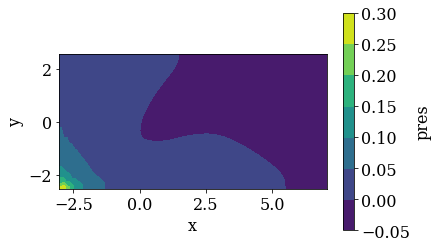

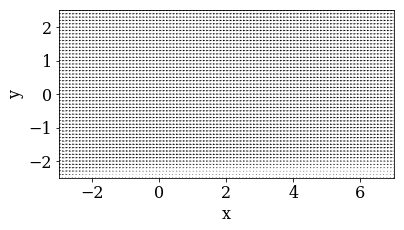

In [5]:
mae6225.io.plot_contour(gridc, 'pres')
mae6225.io.plot_vector(gridx,gridy,'velc')